In [217]:
# Initial imports
import os
import pandas as pd
import requests
import datetime
from datetime import datetime, timedelta, date
import alpaca_trade_api as tradeapi
import matplotlib.pyplot as plt

#Twitter API imports
import tweepy as tw

# NLP & Sentiment imports
import re
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from dotenv import load_dotenv
load_dotenv()

True

In [231]:
# Setting twitter access and api keys
bearer_token = os.getenv("TWITTER_BEARER_TOKEN")
consumer_key= os.getenv("TWITTER_API_KEY")
consumer_secret= os.getenv("TWITTER_SECRET_KEY")
access_token= os.getenv("TWITTER_ACCESS_TOKEN")
access_token_secret= os.getenv("TWITTER_ACCESS_TOKEN_SECRET")

# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

alpaca_api = tradeapi.REST(alpaca_api_key, alpaca_secret_key, api_version='v2')

In [232]:
# authentication for twitter
auth = tw.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
twitter_api = tw.API(auth, wait_on_rate_limit=True)

In [233]:
# Download/Update the VADER Lexicon
nltk.download('vader_lexicon')

# Initialize the VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/Kris/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [296]:
############################################################
"""
    Cleans the tweets and removes the included url
"""
############################################################

def remove_url(txt):
    """Replace URLs found in a text string with nothing 
    (i.e. it will remove the URL from the string).

    Parameters
    ----------
    txt : string
        A text string that you want to parse and remove urls.

    Returns
    -------
    The same txt string with url's removed.
    """

    return " ".join(re.sub("([^0-9A-Za-z \t])|(\w+:\/\/\S+)", "", txt).split())



############################################################
"""
    Sentiment calculation based on compound score
"""
############################################################

def get_sentiment(score):
    """
    Calculates the sentiment based on the compound score.
    """
    result = 0  # Neutral by default
    if score >= 0.05:  # Positive
        result = 1
    elif score <= -0.05:  # Negative
        result = -1

    return result



############################################################
"""
    Function that computes the daily average compound sentiment of tweets.
"""
############################################################

def twitter_sentiment_summarizer_avg(tweets):
    avg_daily_sentiment = []
    for day in tweets:
        day_score = []
        for h in day:
            if h == None:
                continue # error handling
            else:
                day_score.append(analyzer.polarity_scores(h)["compound"])
        avg_daily_sentiment.append(sum(day_score) / len(day_score))
        
    return avg_daily_sentiment



############################################################
"""
    Function that pulls stock data from a given ticker and timeframe.
"""
############################################################

def daily_returns(ticker, timeframe):
        
    # Set current date and the date from one month ago using the ISO format
    current_date = pd.Timestamp.now(tz="America/New_York").isoformat()
    past_date = pd.Timestamp("2020-12-01", tz="America/New_York").isoformat()

    # Get 4 weeks worth of historical data for AAPL
    df = alpaca_api.get_barset(
        ticker,
        timeframe,
        limit=None,
        start=past_date,
        end=current_date,
        after=None,
        until=None,
    ).df
        
    return df



############################################################
"""
    Twitter: Scrape Tweets and Analyze Sentiment
"""
############################################################

def twitter_sentiment(search_words, date_since, items):
    
    # initializing the tweets dataframe
    df = []
    
############################################################
    
    def twitter_sentiment_summarizer_avg(tweets):
    avg_daily_sentiment = []
    
    for day in tweets
        day_score = []
        if pd.Timestamp(tweet.created_at)
            avg_daily_sentiment.append(sum(day_score) / len(day_score))
        else
            day_score.append(analyzer.polarity_scores(h)["compound"])
    
    
    
    
    for day in tweets:
        day_score = []
        for h in day:
            if h == None:
                continue # error handling
            else:
                day_score.append(analyzer.polarity_scores(h)["compound"])
        avg_daily_sentiment.append(sum(day_score) / len(day_score))
        
    return avg_daily_sentiment

############################################################
    
    # adding retweet filter to search words
    search_words = search_words + " -filter:retweets"
    
    # Fetch top tweets/hastags for given ticker
    tweets = tw.Cursor(twitter_api.search,
              q=search_words,
              lang="en",
              since=date_since
                    ).items(items)

    for tweet in tweets:
    
        #Clean text of tweets
        tweet_clean = remove_url(tweet.text)

        # Get date of tweet
        tweet_date = pd.Timestamp(tweet.created_at)
    
        try:
            sentiment = analyzer.polarity_scores(tweet_clean)
            compound = sentiment["compound"]
            pos = sentiment["pos"]
            neu = sentiment["neu"]
            neg = sentiment["neg"]
            normalized = get_sentiment(compound)
        
            df.append({
                "date": tweet_date,
                "tweet": tweet_clean,
                "compound": compound,
                "positive": pos,
                "negative": neg,
                "neutral": neu,
                "normalized": normalized
            
            })
        
        except AttributeError:
            pass
    
    df = pd.DataFrame(df).set_index(["date"])
    
    return df


In [303]:
# tweepy variables
search_words = "microsoft"
date_since = "2020-12-01"
items = 5000

# call the twitter sentiment function and return a dataframe
twitter_df = twitter_sentiment(search_words, date_since, items)
twitter_df.index = twitter_df.index.date
twitter_df

,tweet,compound,positive,negative,neutral,normalized
2021-01-10,microsoft paint brush fun,0.5106,0.524,0.000,0.476,1
2021-01-10,SinglePage Application with amp jQuery HandsOn ad,0.0000,0.000,0.000,1.000,0
2021-01-10,lucascisace Microsoft Xbox Which ones,0.0000,0.000,0.000,1.000,0
2021-01-10,BipinSingh Microsoft Team is best you can crea...,0.7430,0.270,0.000,0.730,1
2021-01-10,Anthony95917760 Microsoft Xbox i just bought t...,0.0000,0.000,0.000,1.000,0
...,...,...,...,...,...,...
2021-01-09,redsteeze Thanks Microsoft,0.4404,0.592,0.000,0.408,1
2021-01-09,miraaksoys philipccoggin Microsoft You appear ...,-0.3612,0.077,0.154,0.769,-1
2021-01-09,Crink20 kirstiealley Yeah its Microsoft that m...,0.6028,0.246,0.080,0.674,1
2021-01-09,Hawley campaign contributors include Comast Ch...,-0.5423,0.000,0.189,0.811,-1


In [304]:
# Get descriptive stats from the DataFrame
twitter_df.describe()

,compound,positive,negative,neutral,normalized
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.094892,0.100562,0.053765,0.845679,0.206400
std,0.365265,0.126367,0.101029,0.148784,0.771439
min,-0.945400,0.000000,0.000000,0.000000,-1.000000
25%,0.000000,0.000000,0.000000,0.747000,0.000000
50%,0.000000,0.000000,0.000000,0.861000,0.000000
75%,0.361200,0.170250,0.095250,1.000000,1.000000
max,0.941300,1.000000,1.000000,1.000000,1.000000


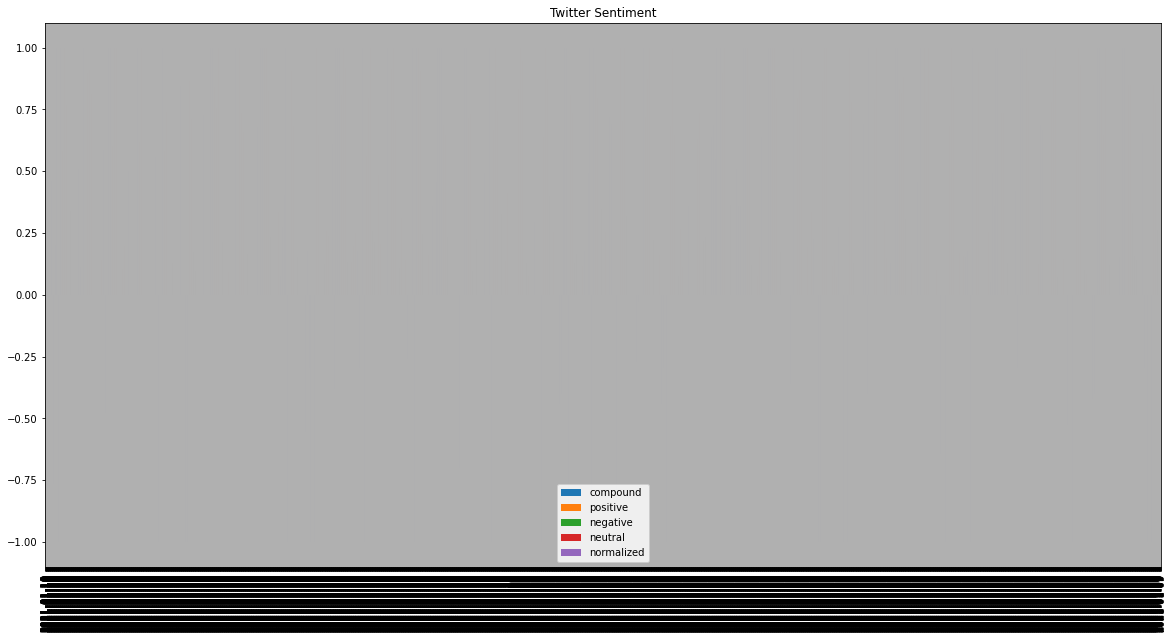

In [305]:
twitter_df.plot(
    y=["compound", "positive", "negative", "neutral", "normalized"],
    kind="bar",
    title= "Twitter Sentiment",
    figsize= (20,10),
    grid=True,
);


In [309]:
# alpaca api variables
ticker = "MSFT"
timeframe = "1D"

# call the alpaca api and return a dataframe of daily returns
daily_df = daily_returns(ticker, timeframe)


# Drop Outer Table Level and drop extra columns
daily_df = daily_df.droplevel(axis=1, level=0)
daily_df = daily_df.drop(columns=["open", "high", "low", "volume"])

# remove the time component of the data
daily_df.index = daily_df.index.date


returns_df = daily_df.pct_change().dropna()
returns_df

,close
2020-12-02,-0.003654
2020-12-03,-0.005338
2020-12-04,0.000607
2020-12-07,-0.000373
2020-12-08,0.007792
2020-12-09,-0.021205
2020-12-10,-0.004233
2020-12-11,0.013087
2020-12-14,0.004314
2020-12-15,-0.000140


In [310]:
# Get averages of each topics sentiment
twitter_avg = twitter_sentiment_summarizer_avg(twitter_df["tweet"])
sentiment_daily_avg = pd.DataFrame(
    {
        "twitter_avg": twitter_avg,
    }
)

sentiment_daily_avg.index = pd.to_datetime(twitter_df.index)
sentiment_daily_avg

,twitter_avg
2021-01-10,0.0
2021-01-10,0.0
2021-01-10,0.0
2021-01-10,0.0
2021-01-10,0.0
...,...
2021-01-09,0.0
2021-01-09,0.0
2021-01-09,0.0
2021-01-09,0.0


In [308]:
combined_df = returns_df.join(sentiment_daily_avg).dropna(how="any")

display(combined_df)

,close,twitter_avg


In [ ]:
# Correlate the twitter sentiment to returns
combined_df.corr().style.background_gradient()